In [6]:
# Requests for handling HTTP get and other requests
import requests
import time # import for playing nice and not getting blocked
import pandas as pd
# from BeautifulSoup4 import BeatifulSoup if installed through pip install BeautifulSoup4
# 
from bs4 import BeautifulSoup

In [37]:
#url = "https://www.ss.com/lv/real-estate/homes-summer-residences/ogre-and-reg/sell/" # chose your starting url here
url = "https://www.ss.lv/lv/real-estate/flats/riga/ziepniekkalns/sell/"
url

'https://www.ss.lv/lv/real-estate/flats/riga/ziepniekkalns/sell/'

In [38]:
# lets combine the above cells into a function which will always get us columns
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]] # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

# lets make a function from the above doodle and make it work on most pages on SS
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

def getRow(row,colist):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

# so if we know how to work on single row then we can do process multiple rows
def getRows(rowlist,colist):
    return [getRow(row, colist=colist) for row in rowlist] # so return a list of dictionaries

# so with this function I can get full dataframe from a single page on ss.com not only apartments
def getDFfromURL(url):
    # print("getting data from", url)
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None # maybe return empty dataframe here
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows, columns=column_names)

def getAllLocalUrls(url):
    """Get a list of all urls including paginated pages"""
    results = [url] # default is just the url if no extra pages found, teiksim Bolderājai...
    req = requests.get(url)
    if req.status_code != 200:
        print(f"Bad response! {req.status_code}")
        return []
    soup = BeautifulSoup(req.text, 'lxml')
    # we just need a one element
    prevanchor = soup.find('a', {"rel":"prev"}) # find finds first match only
    if prevanchor == None: # means there is only one page of ads
        return results
    href = prevanchor.attrs.get('href')
    lastPageNum = int(href.split('/page')[-1].split('.html')[0])
    print("Last page is",lastPageNum)
    nurls = [f"{url}page{n}.html" for n in range(2,lastPageNum+1)]
    results += nurls
    return results

def get_all_ads_df(start_url, save_excel_path=None):
    df_list=[] # so we will save our dataframes in a list
    local_urls = getAllLocalUrls(start_url)
    for url in local_urls:
        print(f"Gathering data from {url}")
        df_list.append(getDFfromURL(url))
        time.sleep(0.3) # we need this to play nice! to avoid rate limit or IP ban!!
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    big_df = pd.concat(df_list) # then make a big dataframe from all the small dataframes
    if save_excel_path:
        big_df.to_excel(save_excel_path)
    return big_df

In [39]:
saab_url = "https://www.ss.com/lv/transport/cars/saab/sell/"

In [40]:
df = get_all_ads_df(saab_url, save_excel_path="saab_10112021.xlsx")

Last page is 2
Gathering data from https://www.ss.com/lv/transport/cars/saab/sell/
Gathering data from https://www.ss.com/lv/transport/cars/saab/sell/page2.html


In [41]:
ziepniekkalns = get_all_ads_df(url,  save_excel_path="Ziepniekkalns _10nov.xlsx")
ziepniekkalns.shape

Last page is 3
Gathering data from https://www.ss.lv/lv/real-estate/flats/riga/ziepniekkalns/sell/
Gathering data from https://www.ss.lv/lv/real-estate/flats/riga/ziepniekkalns/sell/page2.html
Gathering data from https://www.ss.lv/lv/real-estate/flats/riga/ziepniekkalns/sell/page3.html


(84, 9)

In [42]:
ziepniekkalns

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena
0,Remontējams 2-istabu dzīvoklis lieliskā lokāci...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Valdeķu 55,2,61,3/10,119.,"1,000 €","61,000 €"
1,Tiek pārdots vai mainīts uz 2-istabu dzīvokli ...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 18,3,76,2/9,119.,961 €,"73,000 €"
2,Netālu no Sala tilta tiek pārdots 2ist. dzīvok...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Rendas 2,2,41,1/2,P. kara,561 €,"23,000 €"
3,"Продаю светлую, тёплую квартиру с мебелью и бы...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Valdeķu 53,3,75,9/10,119.,"1,093 €","82,000 €"
4,"Pārdošanā dzīvoklis normālā stāvoklī, silts, s...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 48,1,45,3/9,M. ģim.,878 €,"39,500 €"
...,...,...,...,...,...,...,...,...,...
19,"Piedāvājam iegādāties 1 istabas dzīvokli, 36.3...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 57,1,37,6/9,602.,"1,189 €","44,000 €"
20,"Šarmants īpašums Pārdaugavā, Atgāzenē. Pircēji...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Vienības g. 87,3,78,2/3,Renov.,"1,910 €","149,000 €"
21,Pārdodu īpašumu ar kopējo platību 52.9 m2. Ir ...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Bauskas 158,3,53,2/2,P. kara,462 €,"24,500 €"
22,"Abas istabas ir izolētas, dzīvoklis ir gaišs, ...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 16k1,2,60,7/10,119.,"1,133 €","68,000 €"


In [43]:
ziepniekkalns.shape

(84, 9)

In [44]:
ziepniekkalns.columns

Index(['description', 'url', 'Iela', 'Ist.', 'm2', 'Stāvs', 'Sērija',
       'Cena, m2', 'Cena'],
      dtype='object')

In [51]:
ziepniekkalns["price"] = ziepniekkalns.Cena.str.split(' ').str[0]
ziepniekkalns.head()

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,Floor,MaxFloor,price
0,Remontējams 2-istabu dzīvoklis lieliskā lokāci...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Valdeķu 55,2,61,3/10,119.,"1,000 €","61,000 €",3,10,"61,000"
1,Tiek pārdots vai mainīts uz 2-istabu dzīvokli ...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 18,3,76,2/9,119.,961 €,"73,000 €",2,9,"73,000"
2,Netālu no Sala tilta tiek pārdots 2ist. dzīvok...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Rendas 2,2,41,1/2,P. kara,561 €,"23,000 €",1,2,"23,000"
3,"Продаю светлую, тёплую квартиру с мебелью и бы...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Valdeķu 53,3,75,9/10,119.,"1,093 €","82,000 €",9,10,"82,000"
4,"Pārdošanā dzīvoklis normālā stāvoklī, silts, s...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 48,1,45,3/9,M. ģim.,878 €,"39,500 €",3,9,"39,500"


In [52]:
#we can do more post processing - feature engineering using existing columns
ziepniekkalns[['Floor','MaxFloor']] = ziepniekkalns.Stāvs.str.split("/",expand=True) 
ziepniekkalns.head()
ziepniekkalns.price = ziepniekkalns.price.str.replace(",","").astype('int32') # so clean string of , and then convert to integer
ziepniekkalns.head()

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,Floor,MaxFloor,price
0,Remontējams 2-istabu dzīvoklis lieliskā lokāci...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Valdeķu 55,2,61,3/10,119.,"1,000 €","61,000 €",3,10,61000
1,Tiek pārdots vai mainīts uz 2-istabu dzīvokli ...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 18,3,76,2/9,119.,961 €,"73,000 €",2,9,73000
2,Netālu no Sala tilta tiek pārdots 2ist. dzīvok...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Rendas 2,2,41,1/2,P. kara,561 €,"23,000 €",1,2,23000
3,"Продаю светлую, тёплую квартиру с мебелью и бы...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Valdeķu 53,3,75,9/10,119.,"1,093 €","82,000 €",9,10,82000
4,"Pārdošanā dzīvoklis normālā stāvoklī, silts, s...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 48,1,45,3/9,M. ģim.,878 €,"39,500 €",3,9,39500


In [53]:
ziepniekkalns

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,Floor,MaxFloor,price
0,Remontējams 2-istabu dzīvoklis lieliskā lokāci...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Valdeķu 55,2,61,3/10,119.,"1,000 €","61,000 €",3,10,61000
1,Tiek pārdots vai mainīts uz 2-istabu dzīvokli ...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 18,3,76,2/9,119.,961 €,"73,000 €",2,9,73000
2,Netālu no Sala tilta tiek pārdots 2ist. dzīvok...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Rendas 2,2,41,1/2,P. kara,561 €,"23,000 €",1,2,23000
3,"Продаю светлую, тёплую квартиру с мебелью и бы...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Valdeķu 53,3,75,9/10,119.,"1,093 €","82,000 €",9,10,82000
4,"Pārdošanā dzīvoklis normālā stāvoklī, silts, s...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 48,1,45,3/9,M. ģim.,878 €,"39,500 €",3,9,39500
...,...,...,...,...,...,...,...,...,...,...,...,...
19,"Piedāvājam iegādāties 1 istabas dzīvokli, 36.3...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 57,1,37,6/9,602.,"1,189 €","44,000 €",6,9,44000
20,"Šarmants īpašums Pārdaugavā, Atgāzenē. Pircēji...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Vienības g. 87,3,78,2/3,Renov.,"1,910 €","149,000 €",2,3,149000
21,Pārdodu īpašumu ar kopējo platību 52.9 m2. Ir ...,https://ss.com/msg/lv/real-estate/flats/riga/z...,Bauskas 158,3,53,2/2,P. kara,462 €,"24,500 €",2,2,24500
22,"Abas istabas ir izolētas, dzīvoklis ir gaišs, ...",https://ss.com/msg/lv/real-estate/flats/riga/z...,Ozolciema 16k1,2,60,7/10,119.,"1,133 €","68,000 €",7,10,68000


In [69]:
grouped_by_floor = ziepniekkalns.groupby(by="MaxFloor")['price'].agg(["count", "min", "max", "mean", ] ).to_excel("c:/temp/Ziepniekkalns _10nov.xlsx") # i could this with absolute path
grouped_by_floor 

In [68]:
ziepniekkalns.to_excel("c:/temp/Ziepniekkalns _10nov.xlsx") # i could this with absolute path

In [63]:
ziepniekkalns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 23
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  84 non-null     object
 1   url          84 non-null     object
 2   Iela         84 non-null     object
 3   Ist.         84 non-null     object
 4   m2           84 non-null     object
 5   Stāvs        84 non-null     object
 6   Sērija       84 non-null     object
 7   Cena, m2     84 non-null     object
 8   Cena         84 non-null     object
 9   Floor        84 non-null     object
 10  MaxFloor     84 non-null     object
 11  price        84 non-null     int32 
dtypes: int32(1), object(11)
memory usage: 10.3+ KB


<AxesSubplot:>

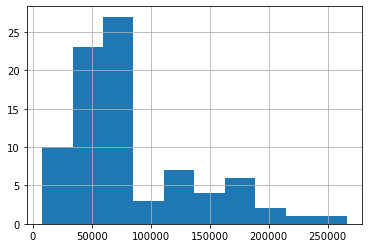

In [61]:
ziepniekkalns.price.hist()

In [27]:
ogre.sqm.hist(bins=50)

NameError: name 'ogre' is not defined

In [64]:
import plotly.express as px

ModuleNotFoundError: No module named 'plotly'

In [65]:
fig = px.histogram(ogre, x="price", nbins=100)
fig.show()

NameError: name 'px' is not defined